### Dealing with Class Imbalance

Positive COVID tests are rare in this dataset (a negative covid test is ~70 times more common than a positive one). If we don't adjust for that, the model could achieve a very high accuracy rate by simply predicting a negative test for every scenario.

This is a common scenario in detecting rare events. This is a fairly nuanced area of machine learning classification, but for this case, we will look for ways to improve model recall (see below)

To address this, we'll tell the Random Forest to **give more weight to rare classes** by setting class weights, either to "balanced" or by establishing our own weighting ratios for positive and negative test results. This helps the model pay more attention to underrepresented cases.

#### Accuracy: 

How often did the predicted value match the actual value

#### Precision: 

When you predicted a positive result, how often was the actual value positive?

#### Recall: 

When the actual value was positive, how often did you predict a positive value?

#### Visual:

https://en.wikipedia.org/wiki/Precision_and_recall

In [1]:
#!pip install pandasql

In [2]:
import pandas as pd

import numpy as np

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_symptoms = pd.read_csv('test_data/results_symptoms.csv')

In [5]:
# it can be useful to set a numerical id for each row as a column
df_symptoms["id"] = df_symptoms.index

In [6]:
df_symptoms.head(5)

,covid19_test_results,temperature,high_risk_exposure_occupation,high_risk_interactions,labored_respiration,rhonchi,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,wheezes,id
0,0,37.00,0,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0
1,0,36.75,0,0,0,1,0,-1,0,0,-1,0,0,0,0,0,0,0,0,1,1
2,0,36.95,0,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,2
3,0,36.85,0,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,3
4,0,37.00,0,1,0,0,0,-1,0,0,-1,0,1,1,0,0,0,0,0,0,4


In [7]:
# Get the unique classes from y_train
# Compute balanced weights for each class based on their frequency in y_train
# Create a dictionary mapping each class to its computed weight
# Print the dictionary and the ratio of the weight for class 1 over class 0

# Define features and target
X = df_symptoms.iloc[:, 2:-1]
y = df_symptoms['covid19_test_results']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weights = dict(zip(classes, weights))
print(class_weights, class_weights[1]/class_weights[0])

{0: 0.5070852095351814, 1: 35.78477157360406} 70.56954314720812


              precision    recall  f1-score   support

           0       0.99      0.92      0.95     23171
           1       0.04      0.21      0.06       328

    accuracy                           0.91     23499
   macro avg       0.51      0.57      0.51     23499
weighted avg       0.97      0.91      0.94     23499



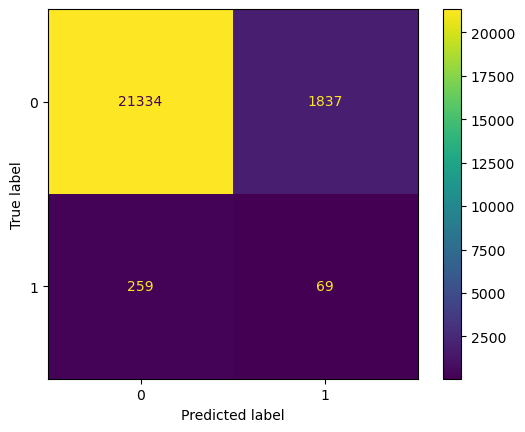

In [8]:
# as an exercise, try changing the class weights to see how
# you can increase recall, and note what impact this has on other
# metrics such as accuracy and precision.
# also, take a look at what it does to predictions, and whether
# the model has started behaving unreliably.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# no class weight adjustment
#rf_balanced = RandomForestClassifier(random_state=42)

#manual class weight adjustment
class_weights = {0: 1.0, 1: 10.0}  # Example: class 1 is weighted 10x more than class 0
rf_balanced = RandomForestClassifier(class_weight=class_weights, random_state=42)

#automatically adjusts the weight for each class inversely proportional to its frequency in the training data.
#per the cell above, this is a 1:70 weighting, which may be so extreme
#it produces unexpected and inaccurate results
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_balanced.fit(X_train, y_train)

# Predictions and evaluation
y_pred_balanced = rf_balanced.predict(X_test)
print(classification_report(y_test, y_pred_balanced))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_balanced, X_test, y_test)

In [9]:
#uncomment if you'd like to see the raw feature imporatances
#commented out because we'll use them to build a pandas
#dataframe for easier visualization
rf_balanced.feature_importances_

array([0.05146963, 0.05521702, 0.00882882, 0.0192401 , 0.13728274,
       0.13522331, 0.09865271, 0.02462005, 0.03599726, 0.02686799,
       0.04389835, 0.06352256, 0.07805045, 0.04900038, 0.03919343,
       0.06635881, 0.04200323, 0.02457315])

In [10]:
feature_df = pd.DataFrame({'feature':df_symptoms.columns[2:-1], 
                           'importance': rf_balanced.feature_importances_})

In [11]:
pysqldf("SELECT * FROM feature_df ORDER BY importance DESC")

,feature,importance
0,cough,0.137283
1,cough_severity,0.135223
2,fever,0.098653
3,loss_of_smell,0.078050
4,muscle_sore,0.066359
5,headache,0.063523
6,high_risk_interactions,0.055217
7,high_risk_exposure_occupation,0.051470
8,loss_of_taste,0.049000
9,fatigue,0.043898


In [12]:
rf_balanced.predict_proba([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])

/Users/nms-workshop/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.71, 0.29]])

In [13]:
# come back to this later, and experiment with it
rf_balanced.predict_proba([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

/Users/nms-workshop/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.3983675, 0.6016325]])

In [14]:
precision, recall, fscore, train_support = score(df_symptoms['covid19_test_results'], y_pred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==df_symptoms['covid19_test_results']).sum()/len(y_pred), 3)))

NameError: name 'y_pred' is not defined

### Comparing Class Balancing and Threshold Adjustment

In this section, we compare three approaches to handling class imbalance:

1. A model trained with **default settings** (no class weighting).
2. A model trained with **`class_weight='balanced'`**, which gives more weight to the minority class during training.
3. A model trained with `class_weight='balanced'`, but evaluated using a **lower decision threshold (e.g., 0.3)** to increase recall.

These strategies address imbalance at different stages:

- **Class weighting** helps the model *learn* more about the minority class during training.
- **Threshold adjustment** lets us *tune the model's behavior* during prediction, trading off precision and recall depending on our goals.

By comparing these side by side, we can see how each technique affects performance—especially in recall, which is often more important when trying to flag rare but important cases.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 1. Model without class balancing
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)

# 2. Model with class_weight='balanced'
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)

# Predict with default threshold (0.5)
y_pred_default = rf_default.predict(X_test)
y_pred_balanced = rf_balanced.predict(X_test)

# Predict with threshold adjustment (e.g., 0.3)
y_probs_balanced = rf_balanced.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs_balanced >= 0.3).astype(int)

# Show results
print("=== Default model (no class_weight) ===")
print(classification_report(y_test, y_pred_default))

print("=== Balanced model (class_weight='balanced') ===")
print(classification_report(y_test, y_pred_balanced))

print("=== Balanced model + threshold = 0.3 ===")
print(classification_report(y_test, y_pred_thresh))


### Summary: Class Imbalance Strategies

This comparison shows how different modeling strategies affect performance in an imbalanced classification task:

- The **default model** has high overall accuracy, but nearly ignores the minority class (very low recall).
- Adding **`class_weight='balanced'`** helps the model recognize more positive cases, improving recall at the cost of some precision and accuracy.
- Combining class weighting with a **lower decision threshold (e.g., 0.3)** pushes recall even higher, but drastically lowers precision—many false positives are flagged.

This highlights an important trade-off:  
If our goal is to **maximize recall**—such as when prioritizing who gets tested during a resource shortage—then tuning for recall may be appropriate, even if overall accuracy drops.  
A model doesn't need perfect performance to be **useful for decision-making**, especially when guiding how to allocate limited resources.


### Exercise: Custom Class Weights and Threshold Tuning

We're dealing with a lot of moving parts here. We can set a custom class balancer, and we can set a custom threshold (in the above example, we used the class ratio as our balancer, which may be too extreme). 

As an exercise, try combining custom class weights with decision threshold adjustment to see if you improve model performance on imbalanced data. Remember, it's all about trade-offs between precision, recall, and accuracy, you aren't going to find a perfect solution (and considering how hard it would be to predict a covid result without a test, you may struggle to find a useful solution, though a limited model could still be useful for allocating scarce tests, more on this at the end)

**How you might approach this:**

1. Define custom class weights to give more importance to the minority class (e.g., `{0: 1, 1: 15}`).
2. Train your model using these weights.
3. Use `predict_proba()` to get predicted probabilities on your test set.
4. Experiment with different probability thresholds (e.g., 0.5, 0.4, 0.3) to convert probabilities into class predictions.
5. Evaluate how these thresholds affect precision, recall, and F1-score to find a balance that fits your goals.

This hands-on tuning helps you understand the trade-offs and how to tailor models for real-world needs where catching rare but critical cases is vital.


### Dealing with Class Imbalance

Positive COVID tests are rare in this dataset (a negative covid test is ~70 times more common than a positive one). If we don't adjust for that, the model may mostly predict "negative" and still look accurate.

To address this, we'll tell the Random Forest to **give more weight to rare classes** by setting `class_weight='balanced'`. This helps the model pay more attention to underrepresented cases.


### Tutorial Wrap-Up: Purpose and Practical Insights

The primary purpose of this tutorial was to learn how to build and interpret a model, not to understand COVID testing or develop a clinical tool.

It is unlikely that we can build a highly accurate prediction model based on symptoms alone—if such a model existed, why would so much time, energy, and resources be spent on testing? However, even a modest model like this *can* help improve how we allocate those scarce testing resources.

Along these lines, this example clearly illustrates why a model with modest overall performance can still be very useful in practice. Even if accuracy, precision, or F1 scores indicate a very limited model, we can gain valuable insights into which symptoms (features) influence the predictions the most. This understanding can help prioritize further investigation or data collection.

Moreover, by focusing on maximizing recall—catching as many positive cases as possible—the model can help **allocate scarce testing resources more effectively**. In situations where testing capacity is limited, prioritizing individuals flagged by the model for testing can support better public health outcomes, even if the model produces false positives.

Overall, this exercise shows that machine learning models don’t always need to be perfect to add real value. They can aid decision-making by providing interpretable insights and guiding resource allocation in complex, real-world scenarios.

